In [ ]:
import pandas as pd
import numpy as np

from src.populate_db import connect_to_database
from src.analysis_utils import get_words_by_genre, get_word_cloud, get_sentiment

import warnings
warnings.filterwarnings('ignore')

# Exploring Albums

This notebook will answer some basic questions about the albums in the database:
* How many albums each band released on average?
* When did the most releases happen?
* Do the words in the album titles change depending on genre?
* What are the emotions associated with the albums' titles?

Let's query the database and load the data into a dataframe.

In [35]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT album.name, band.name, album.release_date, album.duration, 
               YEAR(band.start_date) AS start_year, 
               YEAR(band.end_date) AS end_year, 
               genre.genre_name AS genre  
               FROM album
               INNER JOIN band ON album.band_id = band.id
               INNER JOIN album_genre ON album.id = album_genre.album_id
               INNER JOIN genre ON album_genre.genre_id = genre.id;
               """)
albums = cursor.fetchall()

In [36]:
albums_df = pd.DataFrame(albums, columns=['Album', 'Band', 'Release', 'Duration', 'Band Start', 'Band End', 'Genre'])
albums_df['Band End'] = albums_df['Band End'].replace(np.nan, 2024)
albums_df.drop_duplicates(subset=['Album', 'Band'], inplace=True)

In [37]:
albums_band_duration = albums_df.dropna(subset=['Band Start'])
albums_band_duration['Band Duration'] = albums_band_duration['Band End'] - albums_band_duration['Band Start']
albums_band_duration.drop(columns=['Band Start', 'Band End'], inplace=True)
albums_band_duration.drop_duplicates(subset=['Album', 'Band'], inplace=True)

## How many albums each band released on average?

A basic description of the number of albums released by band reveals we have some outliers in the data. While 75% of bands released six albums or less, the maximum number of albums by a single band was 53. The frequency distribution of albums by band also shows that the majority of bands released up to three albums.

But some bands have been around for longer than others. Let's check if the band duration is related to the number of albums released!

,Number of Albums
count,2519.000000
mean,4.524017
std,5.202275
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,53.000000


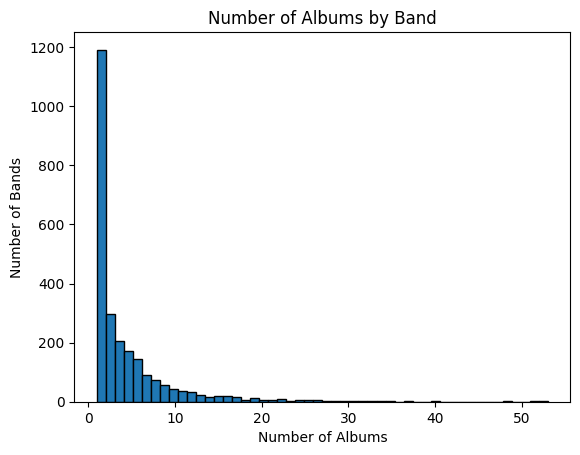

In [38]:
album_count = albums_df.groupby('Band')['Album'].nunique().reset_index()
album_count.columns = ['Band', 'Number of Albums']
album_count['Number of Albums'].plot.hist(
    edgecolor='black', 
    bins=50, 
    xlabel='Number of Albums', 
    ylabel='Number of Bands', 
    title='Number of Albums by Band'
    )
album_count.describe()

The answer is yes, the number of albums is related to how long the band has been active!

The correlation is 43.4%, which means 18.8% of the variation we see in the number of albums can be explained by the duration of the band, but the other 81.2% are due to other factors.

Correlation between Number of Albums and Band Duration:


,Number of Albums,Band Duration
Number of Albums,1.000000,0.433651
Band Duration,0.433651,1.000000


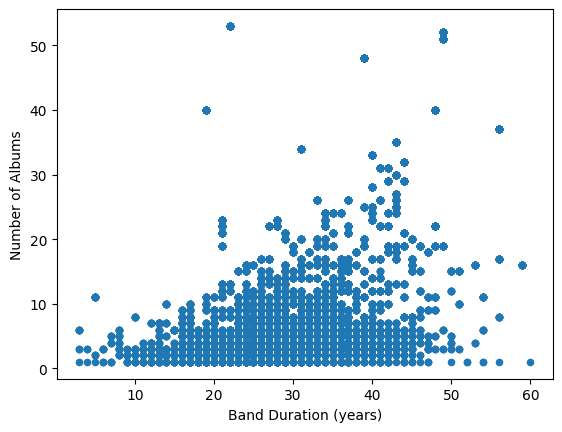

In [9]:
album_count_duration = album_count.merge(albums_band_duration, on='Band')[['Number of Albums', 'Band Duration']]
album_count_duration.plot(kind='scatter', y='Number of Albums', x='Band Duration', xlabel='Band Duration (years)')
print('Correlation between Number of Albums and Band Duration:')
album_count_duration.corr()

## When did the most releases happen?

As we can see there was a steep increase in realeases during the 1980's and 1990's, with a peak in the 2000's. After the 2000's, there is a significant decline in album releases.

This could be explained by a decline in the popularity of metal, but also by a number of iconic bands and musicians breaking up or retiring from this point on.

<Axes: xlabel='Release Decade'>

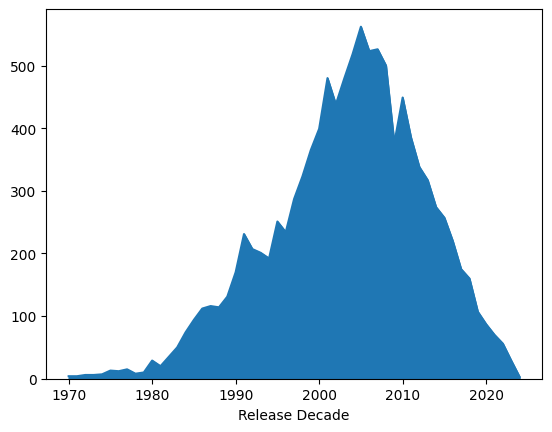

In [10]:
albums_df['Release'] = pd.to_datetime(albums_df['Release']).dt.date
albums_df.dropna(subset=['Release'], inplace=True)
albums_df['Release Decade'] = albums_df['Release'].apply(lambda x: x.year)
albums_df.groupby('Release Decade')['Album'].count().plot.area()

## Do the words in the album titles change depending on genre?

Let's create word clouds for five popular genres in the database to check which words are more frequent in each genre.

Heavy Metal


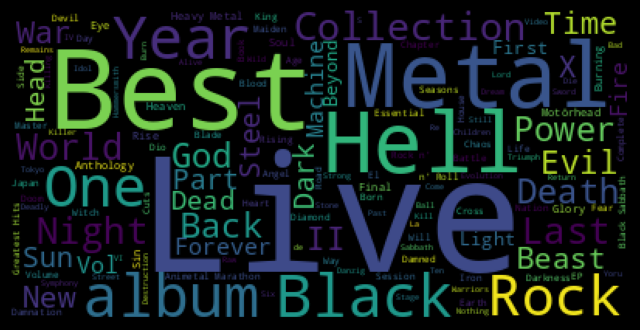

Thrash Metal


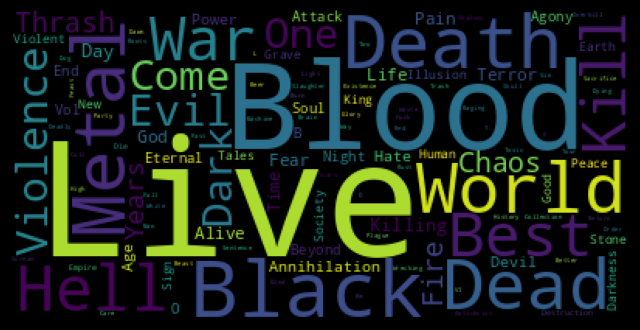

Death Metal


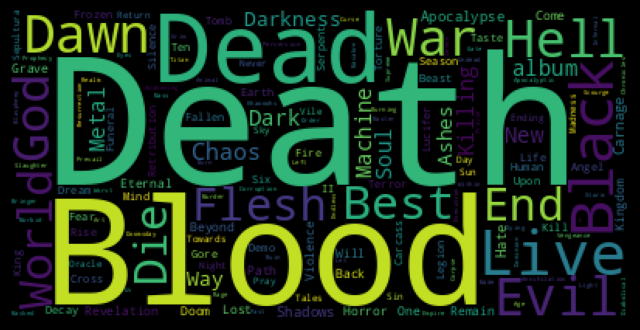

Black Metal


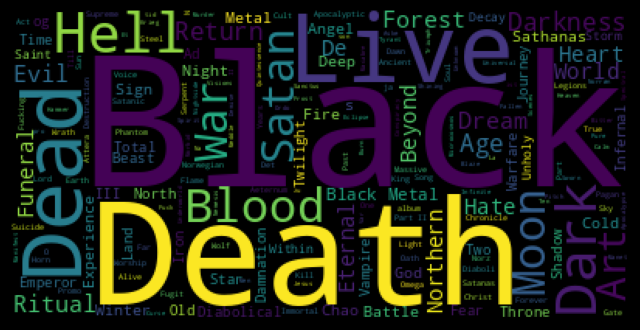

Progressive Metal


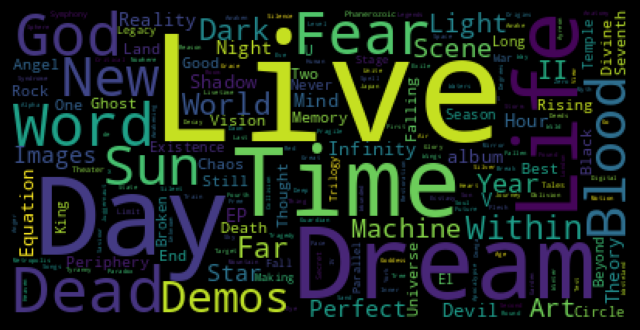

In [39]:
genres = ['heavy metal', 'thrash metal', 'death metal', 'black metal', 'progressive metal']
words = {genre: get_words_by_genre(albums_band_duration, 'Album', genre) for genre in genres}

for genre in genres:
    print(genre.title())
    get_word_cloud(words[genre])

As we can see, many words repeat across genres, such as "dead", "black", and "death", even though they don't always have the same relevance. Another prevalent word is "live" probably due to albums recorded from live concerts.

In addition, the words present in Heavy Metal are consistent with the themes of fantasy, mithology, war, power and glory, good and evil. We can see those themes represented in words like "hell", "evil", "beast", "god", "sun", "light", "steel, "power", and "glory".

For Thrash Metal, common themes are anti-establishment rebellion, war, destruction, and existential dread, represented by words such as "violence", "kill", "evil", "war", "chaos", "dead", "hell", "pain", and "fear".

Similarly, Death Metal focus heavily on violence, death, nihilism, sometimes with gore and graphic descriptions. We can see that in words like "death", "blood", "flesh", "die", "evil", "chaos", "ashes", and "darkness".

When it comes to Black Metal, words like "black", death", "blood", "dark", "funeral", "ritual", "forest", "satan", "hell", and "darkness" illustrate themes like satanism, paganism, worship of nature, and misanthropy.

Progressive Metal, on the other hand, tend to be more conceptual and address themes like personal struggles, introspection, consciouness, reality, science fiction, and fantasy. Words such as "time", "dream", "life", "within", "day", "sun", "star", "infinity", "art", and "reality" illustrate these themes.

## What are the emotions associated with the albums' titles?

To further understand our album titles, let's also perform a [zero-shot classification](https://huggingface.co/tasks/zero-shot-classification) of six emotions (anxiety, depression, happiness, love, anger, and hope) based on the titles by genre. We'll be using [a Facebook's BART checkpoint](https://huggingface.co/facebook/bart-large-mnli) for this task.


In [14]:
album_sentiment = []
labels = ["anxiety", "depression", "happiness", "love", "anger", "hope"]

for genre in genres:
    genre_data = albums_df['Album'][albums_df['Genre'] == genre]
    sentiments = [get_sentiment(song, labels) for song in genre_data if type(song) == str and len(song) > 0]
    sentiments = [
        {'Album': item['sequence'], **dict(zip(item['labels'], item['scores'])), 'Genre': genre}
        for item in sentiments
    ]
    album_sentiment.extend(sentiments)

album_sentiment = pd.DataFrame(album_sentiment)
album_sentiment.to_csv('data/album_sentiment.csv', index=False)

Now let's plot the results!

Anger was the higher scoring emotion in the album titles, surprisingly followed by hope. Next we have anxiety and depression. Love and happiness got the lowest scores, as one would expect.

<Axes: title={'center': "Distribution of Sentiments in the Albums' Titles"}>

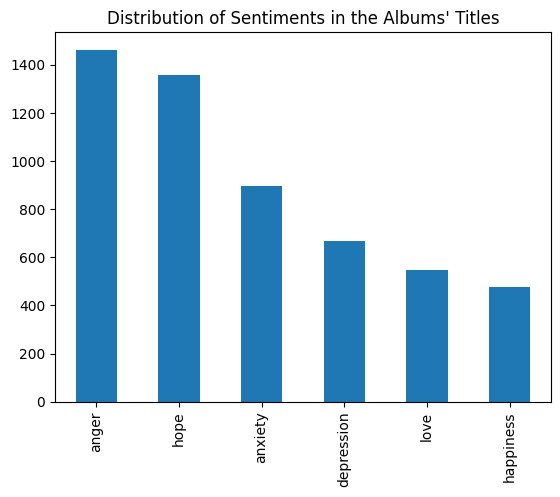

In [28]:
album_sentiment_df = album_sentiment.groupby('Genre')[labels].mean()

album_sentiment.drop(columns=['Album', 'Genre']).sum().sort_values(ascending=False).plot(kind='bar', title="Distribution of Sentiments in the Albums' Titles")

<Axes: title={'center': 'Sentiment Analysis by Genre'}>

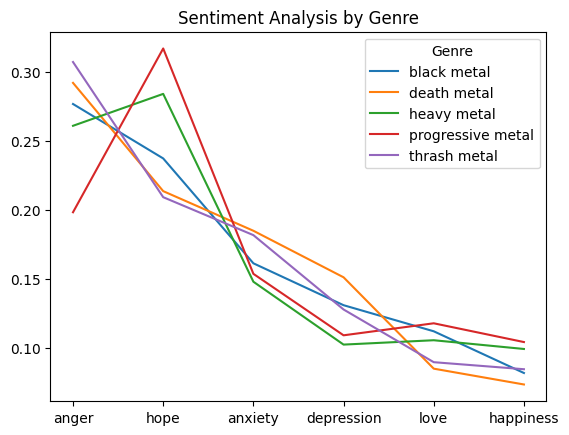

In [34]:
album_sentiment_df.transpose().sort_values(by='thrash metal', ascending=False).plot(title='Sentiment Analysis by Genre')

When it comes to sentiment by genre, anger was the higher scoring emotion for Thrash, Death, and Black Metal, and the second highest for Heavy and Progressive Metal. This confirms anger as the most dominant emotion accross subgenres, reflecting the agressive sound and themes related to rebellion and defiance.

Progressive Metal had the highest score on hope, followed by Heavy Metal. As mentioned earlier, this was the second overall highest scoring emotion. Although this was unanticipated, it may reflect the desire for change that comes from songs with socio-political content from some genres. It is also in line with the deeper and more introspective narrative that is sometimes present in Progressive Metal.

Anxiety and depression were highly prevalent emotions in Death and Thrash Metal titles, which were also the least loving and happy of the investigated genres, along with Black Metal. This might be explain by the fact that these genres often explore themes related to agressiveness, violence, and existential dread.

Black Metal has a profile somewhat close to Thrash and Death Metal, mostly focused on anger but slightly higher on hope, perhaps due the connection with nature that may be present in some of the albums. Anxiety is also lower than those genres, as well as depression in comparison with Death Metal. These sentiments are also present in Black Metal, but they are tone down as they may be more related with the anger coming from misanthropy and hatred of certain social norms than depression itself.

It is important to remember, however, that this classification is based in a model trained on general text, so the conclusions we can draw from it are limited. Moreover, fans and non-fans of heavy metal may experience different emotions while listening to violent-themed music ([Thompson et al., 2019](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fppm0000184)), so these results should not be interpreted as a reflection of the listener's emotions.